# Apprentisage non supervisé avec classes

In [1]:
import import_ipynb
import utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# préparation des données pour l'entrainement de 1992 - 2020
data_pop = utils.generate_df_from_files("./data_cleaned/population", "_population")
data_fertility = utils.generate_df_from_files("./data_cleaned/fertility", "_fertility")
data_child = utils.generate_df_from_files("./data_cleaned/child_mortality", "_child_mortality")
data_capita = utils.generate_df_from_files("./data_cleaned/gdp_capita", "_gdp_capita")
data_climat = utils.generate_df_from_files("./", "climate_cleaned")[0]

#years = [1948, 1952, 1956, 1960, 1964, 1968, 1972, 1976, 1980, 1984, 1988, 1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020] #19
years = [1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020] # 8

# Labels des pays
countries = data_pop[11]["country"].values

data_medals = pd.read_csv("./second_part_countries_cleaned_no_normalized.csv")
data_medals = data_medals.T
data_medals.columns = years
data_medals['country'] = data_medals.index
data_medals.reset_index(drop=True, inplace=True)
data_medals = data_medals.drop(data_medals.index[-1])
# Réorganiser le DataFrame : passer les années en une seule colonne 'year'
data_medals_long = pd.melt(data_medals, id_vars=['country'], var_name='year', value_name='medals')

# Changer le nom de la colonne 2021(JO-2020) par 2020
data_pop[18] = data_pop[18].rename(columns={"2021(JO-2020)": "2020"})
data_fertility[18] = data_fertility[18].rename(columns={"2021(JO-2020)": "2020"})
data_child[18] = data_child[18].rename(columns={"2021(JO-2020)": "2020"})
data_capita[18] = data_capita[18].rename(columns={"2021(JO-2020)": "2020"})

# Préparation des données pour les classes en 3 classes pour le score de médailles
label_class_3 = pd.read_csv("labels_class_3_class.csv")
label_class_3 = label_class_3.T
label_class_3 .columns = years
label_class_3['country'] = label_class_3.index
label_class_3.reset_index(drop=True, inplace=True)
label_class_3 = label_class_3.drop(label_class_3.index[-1])

# Réorganiser le DataFrame : passer les années en une seule colonne 'year'
label_class_3_long = pd.melt(label_class_3, id_vars=['country'], var_name='year', value_name='class')


# Initialiser une liste pour stocker toutes les années de données combinées
final_data = []

# Parcourir chaque année pour combiner les données
for i, year in enumerate(years):

    j = i + 11 # 1992 est le 11ème élément de la liste des années jusqu'à 2020

    # Vérifier si l'année existe dans les colonnes des DataFrames
    year_str = str(year)  # Utiliser le format chaîne pour être sûr
    
    if year_str not in data_pop[j].columns:
        print(f"⚠️ L'année {year} n'existe pas dans le DataFrame data_pop[{j}]. Colonnes disponibles : {data_pop[j].columns}")
        continue

    # Récupérer les colonnes pertinentes pour chaque dataset
    pop_df = data_pop[j][["country", year_str]].rename(columns={year_str: "pop"})
    fertility_df = data_fertility[j][["country", year_str]].rename(columns={year_str: "fertility"})
    child_df = data_child[j][["country", year_str]].rename(columns={year_str: "child"})
    capita_df = data_capita[j][["country", year_str]].rename(columns={year_str: "capita"})

    # Joindre les DataFrames sur "country"
    merged_df = pd.DataFrame({"country": countries})
    merged_df = merged_df.merge(pop_df, on="country", how="left")
    merged_df = merged_df.merge(fertility_df, on="country", how="left")
    merged_df = merged_df.merge(child_df, on="country", how="left")
    merged_df = merged_df.merge(capita_df, on="country", how="left")

    # Ajouter l'année dans le DataFrame
    merged_df["year"] = year

    # Réordonner les colonnes pour mettre "year" avant "country"
    cols = ["year"] + [col for col in merged_df.columns if col != "year"]
    merged_df = merged_df[cols]

    # Ajouter les données climatiques (fixes pour chaque pays)
    merged_df = merged_df.merge(data_climat, on="country", how="left")

    # Ajouter au DataFrame final
    final_data.append(merged_df)

# Concaténer toutes les années en un seul DataFrame
final_df = pd.concat(final_data, ignore_index=True)

# Rajouter les médailles
final_df["score"] = data_medals_long["medals"]

# Rajouter les classes pour score
final_df["class"] = label_class_3_long["class"]

# Remplir les valeurs manquantes par 0 pour éviter les NaN dans t-SNE
final_df = final_df.fillna(0)

# Afficher un aperçu
print(final_df.head())

# Créer un array numpy pour t-SNE avec les colonnes pertinentes
X = final_df[['pop', 'fertility', 'child', 'capita', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']].values
y_regression = final_df['score'].values  # Score de médailles pour régression
y_classification = final_df['class'].values  # Score de médailles pour classification
countries_name = final_df['country'].values  # Noms des pays pour annotations

   year    country       pop  fertility     child    capita  Avg_Temperature  \
0  1992    Albania  0.002779   0.259972  0.102065  0.025418         0.550000   
1  1992    Algeria  0.022542   0.449794  0.133229  0.064224         0.500000   
2  1992     Angola  0.010508   0.844567  0.707830  0.030393         0.516667   
3  1992  Argentina  0.028559   0.273728  0.069277  0.137042         0.423077   
4  1992    Armenia  0.003025   0.206327  0.126412  0.024514         0.480000   

   Avg_Precipitation  Avg_Seasonality  Avg_Aridity  score  class  
0           0.600000         0.475000     0.450000    1.0      0  
1           0.360000         0.240000     0.640000   14.0      0  
2           0.483333         0.333333     0.500000    1.0      0  
3           0.469231         0.338462     0.453846   12.0      0  
4           0.460000         0.420000     0.440000    0.0      0  


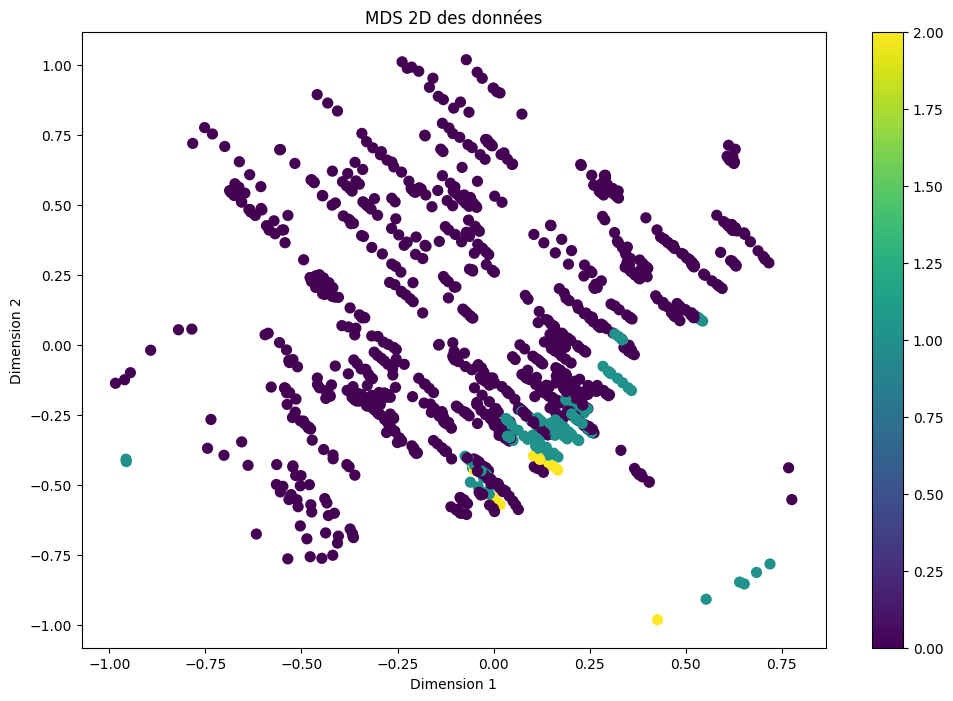

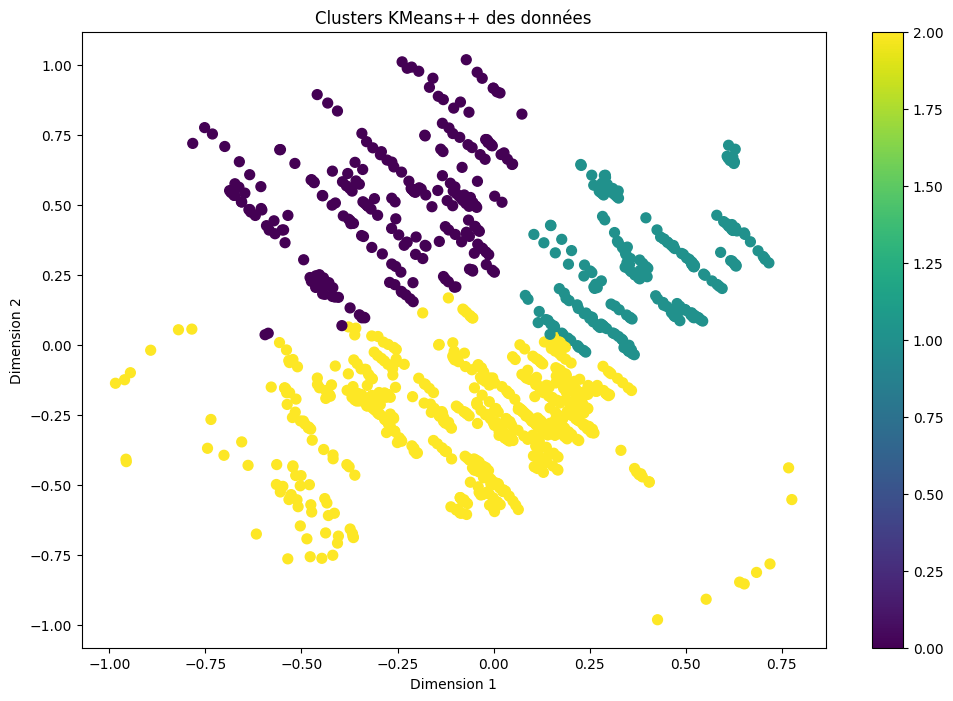

In [13]:
# MDS pour réduire la dimensionnalité et visualiser les données

from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Réduire la dimensionnalité en 2D
embedding = MDS(n_components=2, random_state=42, dissimilarity='euclidean')
X_transformed = embedding.fit_transform(X)

# Afficher les données
plt.figure(figsize=(12, 8))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_classification, cmap='viridis', s=50)
plt.colorbar()
plt.title("MDS 2D des données")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# Clustering des données avec KMeans++ pour la classification avec 3 classes

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialiser le modèle KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)

# Entraîner le modèle
y_kmeans = kmeans.fit_predict(X)

# Afficher les clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_kmeans, cmap='viridis', s=50)
plt.colorbar()
plt.title("Clusters KMeans++ des données")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()



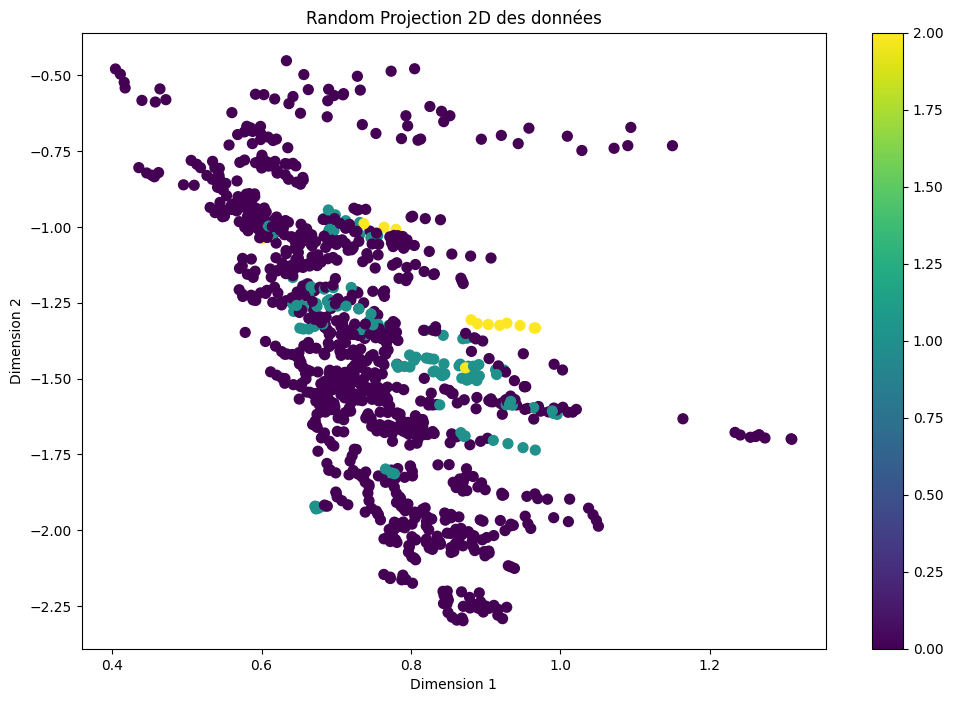

In [10]:
# Random Projection pour réduire la dimensionnalité et visualiser les données

from sklearn.random_projection import GaussianRandomProjection

# Réduire la dimensionnalité en 2D
embedding = GaussianRandomProjection(n_components=2, random_state=42)
X_transformed = embedding.fit_transform(X)

# Afficher les données
plt.figure(figsize=(12, 8))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_classification, cmap='viridis', s=50)
plt.colorbar()
plt.title("Random Projection 2D des données")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

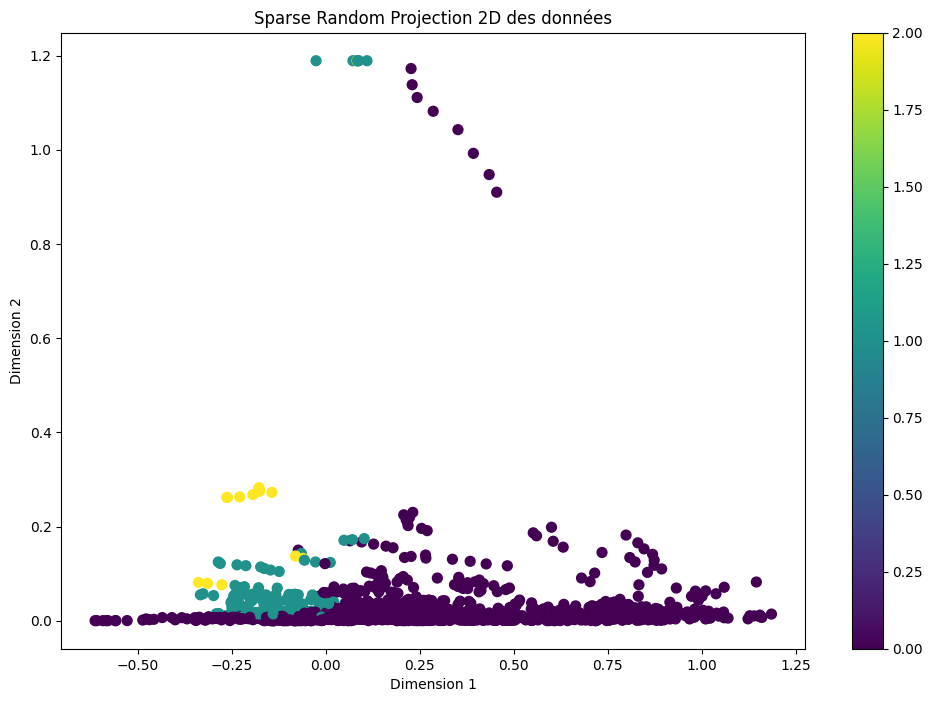

In [14]:
# Random Projection avec SparseRandomProjection

from sklearn.random_projection import SparseRandomProjection

# Réduire la dimensionnalité en 2D
embedding = SparseRandomProjection(n_components=2, random_state=42)
X_transformed = embedding.fit_transform(X)

# Afficher les données
plt.figure(figsize=(12, 8))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_classification, cmap='viridis', s=50)
plt.colorbar()
plt.title("Sparse Random Projection 2D des données")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

## Random Forest Classifier, XGBoost Classifier, Decision Tree Classifier

In [4]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Séparer les données pour l'entraînement et le test
train_df = final_df[final_df["year"] < 2020].copy()  # Copie explicite
test_df = final_df[final_df["year"] == 2020].copy()  # Copie explicite

# Variables explicatives (features) et cible (target)
features = ['pop', 'fertility', 'child', 'capita', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality', 'Avg_Aridity']
target = "class"

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

In [5]:
# Fonction pour afficher la matrice de confusion
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Calcul des métriques de classification
def calculate_classification_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

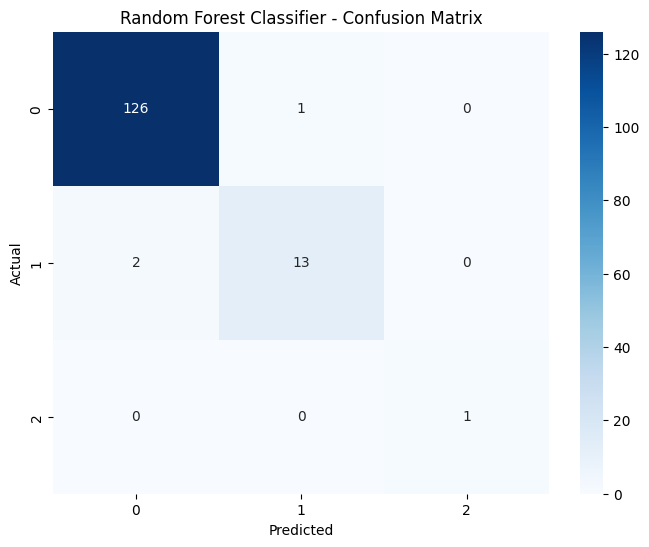

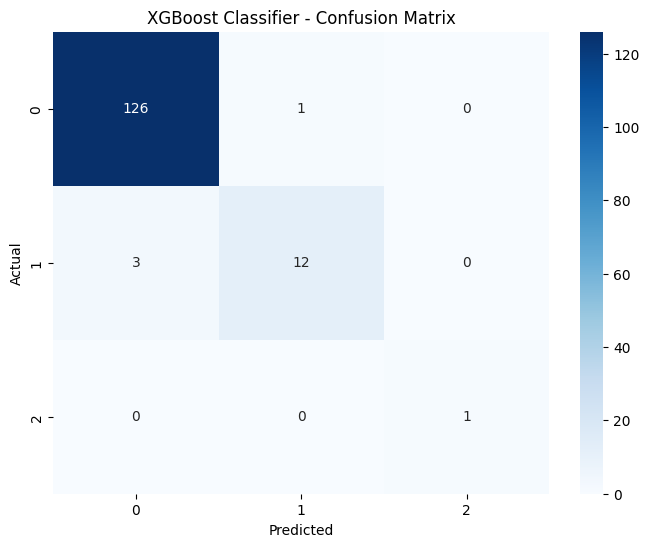

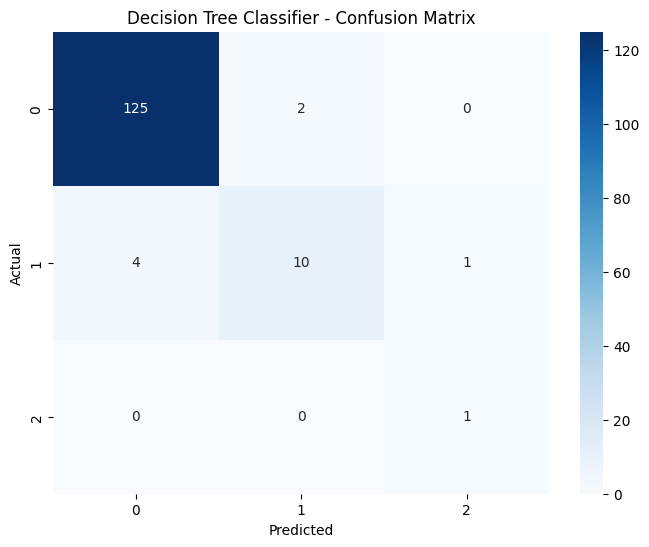

Performance Comparison:
                      Model  Precision    Recall  F1 Score
0  Random Forest Classifier   0.978631  0.979021  0.978700
1        XGBoost Classifier   0.971277  0.972028  0.971138
2  Decision Tree Classifier   0.951483  0.951049  0.949659


In [6]:
# Initialisation des modèles
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
xgb_model = XGBClassifier(random_state=42, n_estimators=100)
dt_model = DecisionTreeClassifier(random_state=42)

# Entraînement des modèles
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

# Prédictions
rf_predictions = rf_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)
dt_predictions = dt_model.predict(X_test)

# Calcul des métriques pour chaque modèle
rf_precision, rf_recall, rf_f1 = calculate_classification_metrics(y_test, rf_predictions)
xgb_precision, xgb_recall, xgb_f1 = calculate_classification_metrics(y_test, xgb_predictions)
dt_precision, dt_recall, dt_f1 = calculate_classification_metrics(y_test, dt_predictions)

# Affichage des matrices de confusion
plot_confusion_matrix(y_test, rf_predictions, "Random Forest Classifier - Confusion Matrix")
plot_confusion_matrix(y_test, xgb_predictions, "XGBoost Classifier - Confusion Matrix")
plot_confusion_matrix(y_test, dt_predictions, "Decision Tree Classifier - Confusion Matrix")

# Compilation des résultats
classification_results = pd.DataFrame({
    "Model": ["Random Forest Classifier", "XGBoost Classifier", "Decision Tree Classifier"],
    "Precision": [rf_precision, xgb_precision, dt_precision],
    "Recall": [rf_recall, xgb_recall, dt_recall],
    "F1 Score": [rf_f1, xgb_f1, dt_f1]
})

print("Performance Comparison:")
print(classification_results)

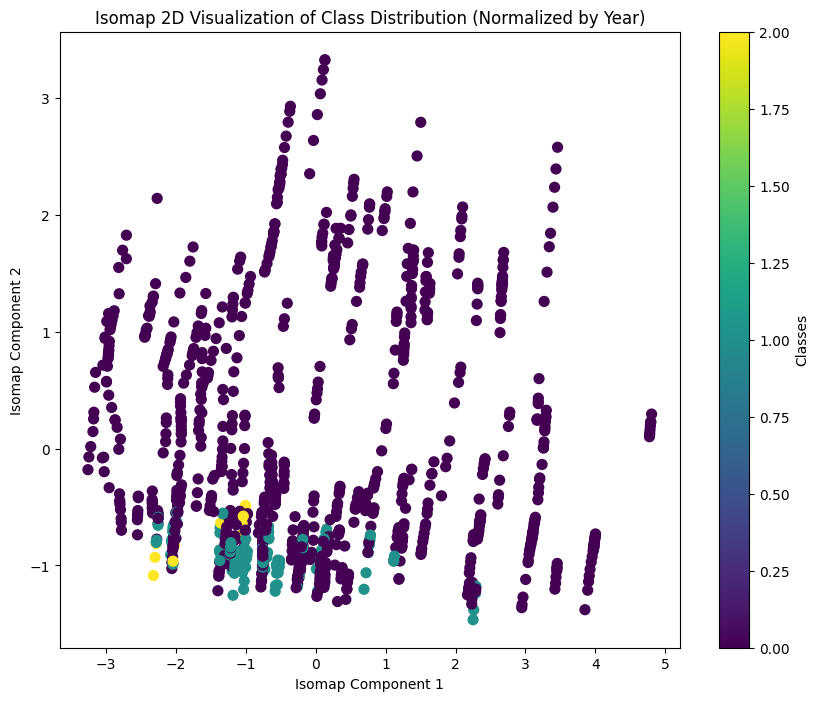

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# Fonction pour normaliser les données par année
def normalize_by_year(df, features):
    df_normalized = pd.DataFrame()
    years = df["year"].unique()  # Liste des années
    
    for year in years:
        df_year = df[df["year"] == year].copy()  # Sous-ensemble par année
        scaler = StandardScaler()
        df_year[features] = scaler.fit_transform(df_year[features])  # Normalisation des features
        df_normalized = pd.concat([df_normalized, df_year], ignore_index=True)  # Ajout des données normalisées
    
    return df_normalized

# Normalisation des données par année
features = [ 'fertility', 'Avg_Temperature', 'Avg_Precipitation', 'Avg_Seasonality']
final_df_normalized = normalize_by_year(final_df, features)

# Préparer les données pour l'Isomap
X_clustering = final_df_normalized[features].values
y_classification = final_df_normalized['class'].values  # Classes cibles pour la visualisation

# Appliquer Isomap pour réduire les données en 2D
isomap = Isomap(n_neighbors=100, n_components=2)
X_2d = isomap.fit_transform(X_clustering)

# Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_classification, cmap='viridis', s=50)
plt.title("Isomap 2D Visualization of Class Distribution (Normalized by Year)")
plt.xlabel("Isomap Component 1")
plt.ylabel("Isomap Component 2")
plt.colorbar(scatter, label='Classes')
plt.show()


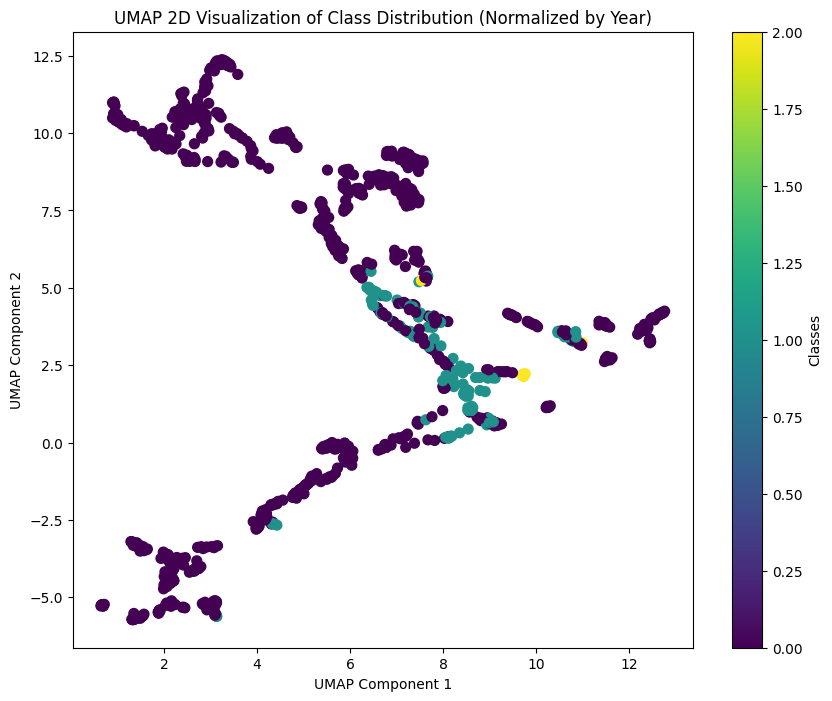

In [18]:
import umap.umap_ as umap  # Importation de la version UMAP compatible avec sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Fonction pour normaliser les données par année
def normalize_by_year(df, features):
    df_normalized = pd.DataFrame()
    years = df["year"].unique()  # Liste des années
    
    for year in years:
        df_year = df[df["year"] == year].copy()  # Sous-ensemble par année
        scaler = StandardScaler()
        df_year[features] = scaler.fit_transform(df_year[features])  # Normalisation des features
        df_normalized = pd.concat([df_normalized, df_year], ignore_index=True)  # Ajout des données normalisées
    
    return df_normalized

# Normalisation des données par année
features = ['fertility', 'child', 'capita', 'Avg_Precipitation', 'Avg_Seasonality']
final_df_normalized = normalize_by_year(final_df, features)

# Préparer les données pour UMAP
X_clustering = final_df_normalized[features].values
y_classification = final_df_normalized['class'].values  # Classes cibles pour la visualisation

# Appliquer UMAP pour réduire les données en 2D
umap_2d = umap.UMAP(n_neighbors=70, n_components=2)
X_umap_2d = umap_2d.fit_transform(X_clustering)

# Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y_classification, cmap='viridis', s=50)
plt.title("UMAP 2D Visualization of Class Distribution (Normalized by Year)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(scatter, label='Classes')
plt.show()


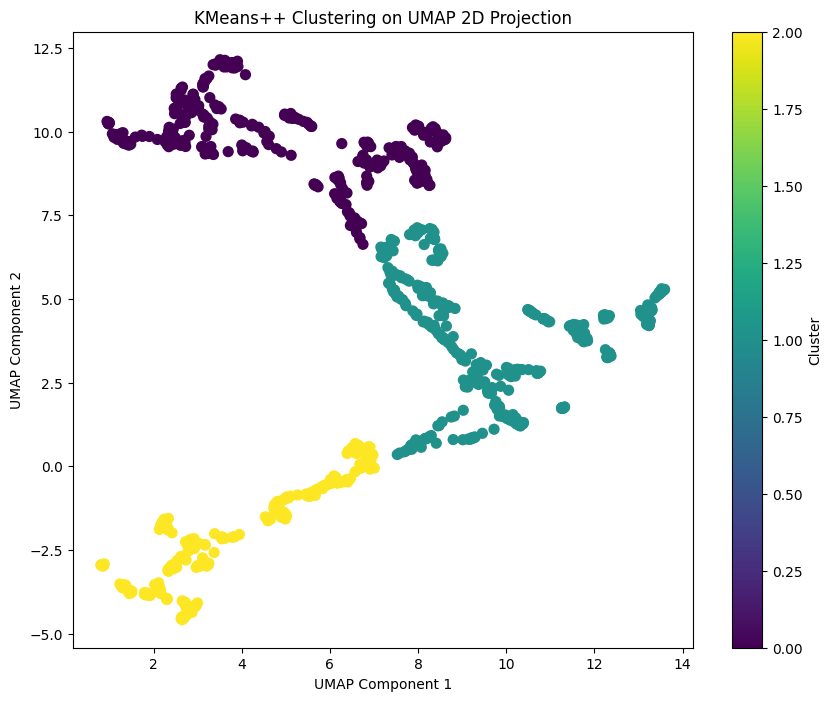

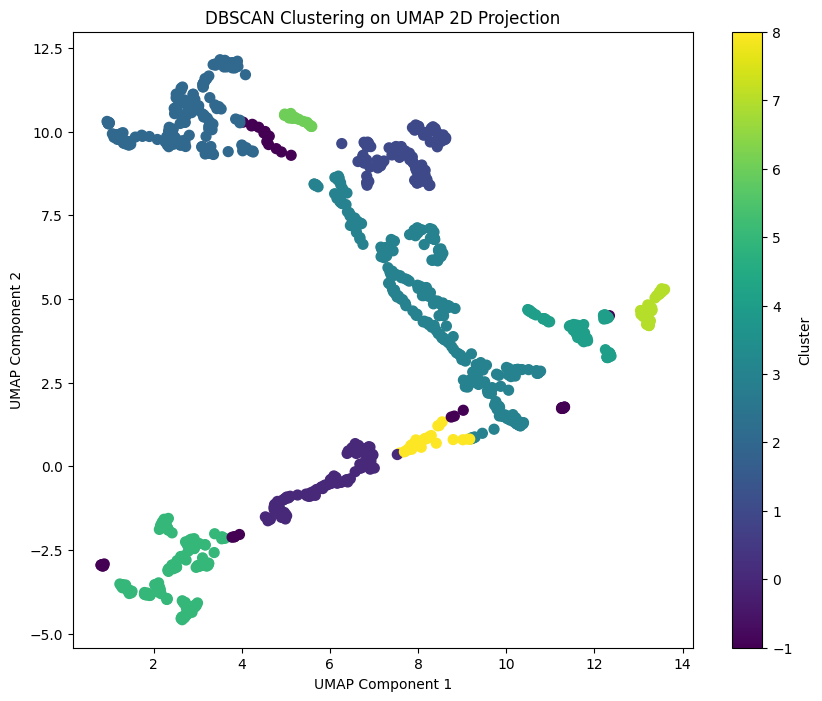

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

# **Clustering avec KMeans++**
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(X_umap_2d)

# **Clustering avec DBSCAN**
dbscan = DBSCAN(eps=0.6, min_samples=20)
dbscan_labels = dbscan.fit_predict(X_umap_2d)

# **Visualisation des résultats KMeans++**
plt.figure(figsize=(10, 8))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.title("KMeans++ Clustering on UMAP 2D Projection")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(label='Cluster')
plt.show()

# **Visualisation des résultats DBSCAN**
plt.figure(figsize=(10, 8))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=dbscan_labels, cmap='viridis', s=50)
plt.title("DBSCAN Clustering on UMAP 2D Projection")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.colorbar(label='Cluster')
plt.show()